# Прогнозирование температуры звезды

**Заказчик исследования:** обсерватория «Небо на ладони».<br>
**Задача:** придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.<br>

Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.<br>

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.
В базе обсерватории есть характеристики уже изученных 240 звёзд.

**Характеристики:**

- Относительная светимость L/Lo — светимость звезды относительно Солнца.
- Относительный радиус R/Ro — радиус звезды относительно радиуса Солнца.
- Абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.
- Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- Тип звезды.
- Абсолютная температура T(K) — температура на поверхности звезды в Кельвинах.

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from math import ceil
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.optim import Adam 

In [2]:
data = pd.read_csv('/datasets/6_class.csv', index_col=0)
data.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 13.1+ KB


## EDA

### Количественные данные

In [4]:
def num(column):
    print(column,  '\n')
    print(data[column].describe())
    
    figure, axis = plt.subplots(1, 2, figsize=(13,5))
    
    plt.style.use('bmh')
    
    axis[0].hist(data[column])
    axis[0].set_title('График распределения значений')
    
    axis[1].boxplot(data[column])
    axis[1].set_title('График размаха значений')
    
    figure.suptitle(column)
    plt.show()

In [5]:
numeric = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

Temperature (K) 

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: Temperature (K), dtype: float64


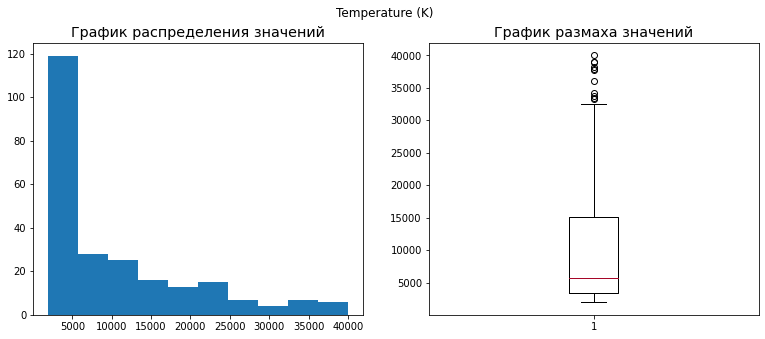

Luminosity(L/Lo) 

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: Luminosity(L/Lo), dtype: float64


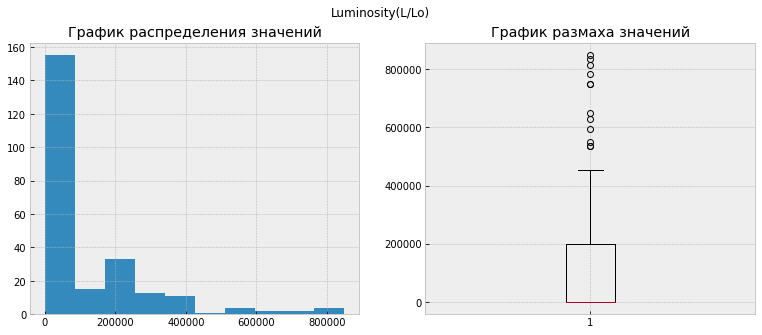

Radius(R/Ro) 

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: Radius(R/Ro), dtype: float64


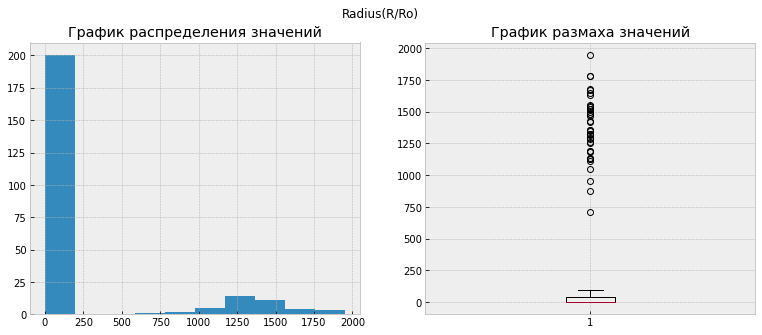

Absolute magnitude(Mv) 

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: Absolute magnitude(Mv), dtype: float64


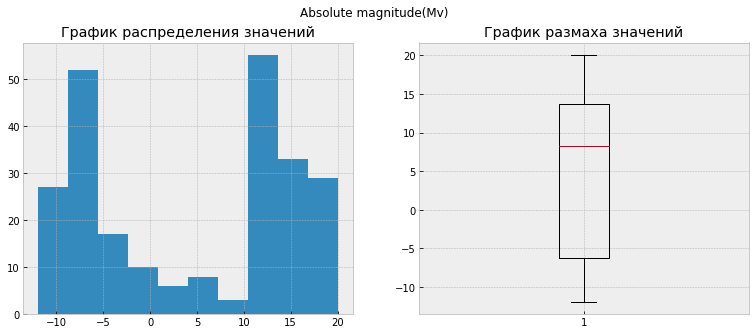

In [6]:
for col in numeric:
    num(col)

In [7]:
# для удобства избавимся от скобок в названиях
data = data.rename(columns={'Temperature (K)': 'Temperature', 
                            'Luminosity(L/Lo)': 'Luminosity',
                            'Radius(R/Ro)': 'Radius',
                            'Absolute magnitude(Mv)': 'Absolute magnitude'})

Данные с температурой распределены неравномерно, но т.к. это целевой признак, то лучше ничего там не удалять.

В данных о радиусе большинство значений околонулевых и не превышающих 250. Удалим оставшиеся за пределами выбросы.

In [8]:
data.query('Radius > 250')

,Temperature,Luminosity,Radius,Absolute magnitude,Star type,Star color
50,3490,270000.0,1520.0,-9.40,5,Red
51,3750,283000.0,1260.0,-7.63,5,Red
52,3834,272000.0,1183.0,-9.20,5,Red
53,3749,550000.0,1648.0,-8.05,5,Orange
54,3650,310000.0,1324.0,-7.79,5,Red
55,3450,263000.0,1349.0,-11.75,5,Red
56,3660,363000.0,1673.0,-11.92,5,Red
57,3450,174000.0,1284.0,-11.28,5,Red
58,3752,209000.0,955.0,-11.24,5,Red
59,3535,195000.0,1546.0,-11.36,5,Red


In [9]:
data = data.query('Radius < 250')

В данных о светимости тоже много выбросов, но их удаление может негативно сказаться на обучении нейросети, поэтому оставим как есть.

Значения абсолютной магнитуды выбросов не имеют, менять не надо.

### Категориальные данные

In [10]:
# изучим значения цветов
data['Star color'].unique() 

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'White-Yellow', 'white', 'Blue ', 'yellowish',
       'Yellowish', 'Orange-Red', 'Blue white ', 'Blue-White'],
      dtype=object)

In [11]:
data['Star color'] = data['Star color'].str.lower().str.strip()

In [12]:
data['Star color'].unique() 

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'blue-white', 'whitish',
       'yellow-white', 'white-yellow', 'yellowish', 'orange-red'],
      dtype=object)

In [13]:
# оставим только основные цвета
data['Star color'] = data['Star color'].replace({'blue white': 'blue',
                                                'yellowish white': 'yellow',
                                                'pale yellow orange': 'yellow',
                                                'blue-white': 'blue',
                                                'whitish': 'white',
                                                'yellow-white': 'yellow',
                                                'white-yellow': 'yellow',
                                                'yellowish': 'yellow',
                                                'orange-red': 'red'})

In [14]:
data['Star color'].unique() 

array(['red', 'blue', 'white', 'yellow'], dtype=object)

In [15]:
def cat(column):
    print(column, '\n')
    print(data[column].value_counts())
    
    names = list(data[column].value_counts().index)
    values = list(data[column].value_counts().values)

    figure, axis = plt.subplots(figsize=(5, 5))
    
    axis.barh(names, values)
    
    plt.style.use('bmh')
    
    figure.suptitle(column)
    plt.show()

In [16]:
categorical = ['Star type', 'Star color']

Star type 

0    40
1    40
2    40
3    40
4    40
Name: Star type, dtype: int64


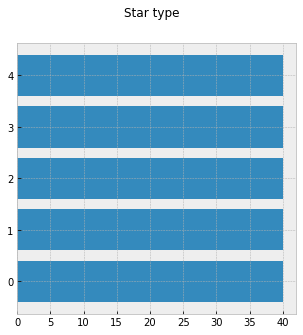

Star color 

red       90
blue      84
yellow    16
white     10
Name: Star color, dtype: int64


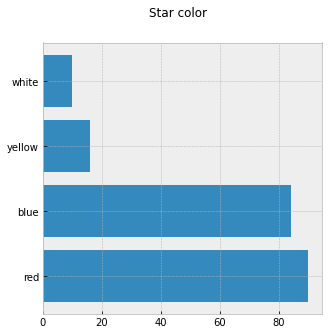

In [17]:
for col in categorical:
    cat(col)

В данных одинаковое количество звёзд каждого типа. Преобладает красный цвет.

### Вывод

- Данные очищены от выбросов
- Звёзды каждого типа представлены равномерно
- Названия цветов приведены к единому формату
- Больше всего звёзд красного цвета

## Подготовка данных к построению модели

In [18]:
features = data.drop('Temperature', axis=1)
target = data['Temperature']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, shuffle=True)

In [20]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(160, 5)
(160,)
(40, 5)
(40,)


In [21]:
numeric = ['Luminosity', 'Radius', 'Absolute magnitude']

In [22]:
# кодирование категориальных признаков
ohe_encoder = OneHotEncoder(handle_unknown='ignore')
ohe_encoder.fit(X_train[categorical])
X_train_encoded = pd.DataFrame(
    ohe_encoder.transform(X_train[categorical]).toarray(),
    columns=ohe_encoder.get_feature_names(categorical)
)

X_train_ohe = pd.concat((X_train[numeric].reset_index(drop=True), X_train_encoded.reset_index(drop=True)), axis=1)

X_test_encoded = pd.DataFrame(
    ohe_encoder.transform(X_test[categorical]).toarray(),
    columns=ohe_encoder.get_feature_names(categorical)
)

X_test_ohe = pd.concat((X_test[numeric].reset_index(drop=True), X_test_encoded.reset_index(drop=True)), axis=1)

In [23]:
# стандартизация числовых признаков
scaler = StandardScaler()
scaler.fit(X_train_ohe[numeric])

X_train_ohe[numeric] = scaler.transform(X_train_ohe[numeric])
X_test_ohe[numeric] = scaler.transform(X_test_ohe[numeric])

In [24]:
X_train_tensor = torch.from_numpy(np.array(X_train_ohe)).float()
X_test_tensor = torch.from_numpy(np.array(X_test_ohe)).float()

y_train_tensor = torch.from_numpy(np.array(y_train)).float()
y_test_tensor = torch.from_numpy(np.array(y_test)).float()

## Построение базовой нейронной сети

In [25]:
# функция активации
def linear(x):
    k = 2
    return k*x

**Архитектура базовой сети:**
- полносвязная сеть прямого распространения
- 2 скрытых слоя
- функция активации для скрытых слоёв - leaky ReLU
- функция активации выходного слоя - линейная

In [26]:
class Basic_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(Basic_Net, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer2(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer3(x)
        x = linear(x)
        
        return x

In [27]:
# инициализация весов
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')

In [28]:
# гиперпараметры нейросети
num_epochs = 6000
batch_size = 100
accumulation_iteration = 5
num_batches = ceil(len(X_train_tensor)/batch_size)
loss = torch.nn.MSELoss()
learning_rate = 0.01

- Входной слой - 12 нейронов
- Скрытые слои - 3 нейрона
- Выходной слой - 1 нейрон

In [29]:
n_in_neurons = X_train_tensor.size(dim=1)
n_out_neurons = 1
n_hidden_neurons_1 = round(np.sqrt(n_in_neurons))
n_hidden_neurons_2 = round(np.sqrt(n_in_neurons))

In [30]:
basic_net = Basic_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
basic_net.apply(init_weights)
optimizer = torch.optim.Adam(basic_net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train_tensor))
    optimizer.zero_grad()
    
    for batch_i in range(num_batches):
        
        start_index = batch_i * batch_size
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = basic_net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        if ((batch_i+1) % accumulation_iteration == 0) or (batch_i+1 == num_batches):
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 100 == 0 or epoch == num_epochs-1:
            basic_net.eval()
            test_preds = basic_net.forward(X_test_tensor).flatten()
            mse = (torch.sum((y_test_tensor - test_preds)**2)/len(test_preds)).data
            rmse = np.sqrt(mse)
            print(f'Эпоха: {epoch}, Loss: {loss_value}, RMSE: {rmse}')
        

Эпоха: 0, Loss: 193528128.0, RMSE: 12411.9609375
Эпоха: 0, Loss: 201502112.0, RMSE: 12411.837890625
Эпоха: 100, Loss: 185119952.0, RMSE: 12353.1435546875
Эпоха: 100, Loss: 211960432.0, RMSE: 12351.0712890625
Эпоха: 200, Loss: 178213760.0, RMSE: 11628.3154296875
Эпоха: 200, Loss: 174839584.0, RMSE: 11614.115234375
Эпоха: 300, Loss: 113323616.0, RMSE: 9436.462890625
Эпоха: 300, Loss: 119658088.0, RMSE: 9408.6826171875
Эпоха: 400, Loss: 66302520.0, RMSE: 6774.95458984375
Эпоха: 400, Loss: 51137220.0, RMSE: 6753.21826171875
Эпоха: 500, Loss: 29843756.0, RMSE: 5302.1884765625
Эпоха: 500, Loss: 58650396.0, RMSE: 5293.7001953125
Эпоха: 600, Loss: 34860940.0, RMSE: 4836.20458984375
Эпоха: 600, Loss: 31010410.0, RMSE: 4834.11279296875
Эпоха: 700, Loss: 31721996.0, RMSE: 4718.1884765625
Эпоха: 700, Loss: 27335032.0, RMSE: 4717.55712890625
Эпоха: 800, Loss: 28789598.0, RMSE: 4677.0361328125
Эпоха: 800, Loss: 26982758.0, RMSE: 4676.9052734375
Эпоха: 900, Loss: 29173876.0, RMSE: 4653.39208984375
Эп

In [31]:
def build_graphic():
    figure, axis = plt.subplots(1, 1, figsize=(10,8))
    
    plt.style.use('bmh')

    axis.bar(x = y_test.index, height = y_test.values, width = 3, label = 'Факт')
    axis.bar(x = y_test.index, height = test_preds.int(), width = 5, alpha=0.5, label = 'Прогноз')

    plt.xlabel("Номер звезды в таблице данных")
    plt.ylabel("Температура звезды")

    figure.suptitle('График')
    plt.legend()
    plt.show()

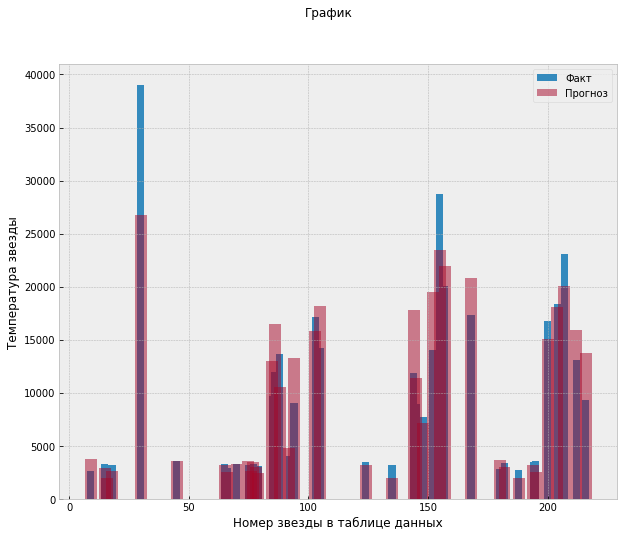

In [32]:
build_graphic()

### Вывод

В целом, нейросеть даёт неплохие результаты. Здесь уже выбраны оптимальное количество эпох, скорость обучения и размер батча.<br>
- Пробовала менять размеры батча 50, 80, 100.<br>
- Скорость обучения 0.0001, 0.1 - слишком маленькая скорость работает медленно, прироста результата не дала. Более высокая скорость пропускает минимумы.<br>
- Количество эпох варьировалось от 100 до 6000 - оставила 6000, т.к. при таком варианте достигается наилучший результат без переобучения.<br>
- Пробовала сначала один скрытый слой - справляется тоже хорошо, но с двумя работает точнее.<br>
- Инициализация весов равномерным/нормальным распределением, fan_in/fan_out - существенных изменений не вносит.<br>
- Функция активации изначально была ReLU, но в данных есть отрицательные значения - решила попробовать leaky ReLU, результат улучшился.<br>

Наилучшее значение метрики RMSE на тестовой выборке - **3526**.

## Улучшение нейронной сети

### BatchNormalization

In [33]:
class BN_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(BN_Net, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer2(x)
        x = self.bn2(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer3(x)
        x = linear(x)
        
        return x

In [34]:
bn_net = BN_Net(n_in_neurons, n_hidden_neurons_1,  n_hidden_neurons_2, n_out_neurons)
bn_net.apply(init_weights)
optimizer = torch.optim.Adam(bn_net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    order = np.random.permutation(len(X_train_tensor))
    optimizer.zero_grad()
    
    for batch_i in range(num_batches):
        
        start_index = batch_i * batch_size
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = bn_net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        if ((batch_i+1) % accumulation_iteration == 0) or (batch_i+1 == num_batches):
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 100 == 0 or epoch == num_epochs-1:
            bn_net.eval()
            test_preds = bn_net.forward(X_test_tensor).flatten()
            mse = (torch.sum((y_test_tensor - test_preds)**2)/len(test_preds)).data
            rmse = np.sqrt(mse)
            print(f'Эпоха: {epoch}, Loss: {loss_value}, RMSE: {rmse}')

Эпоха: 0, Loss: 219758064.0, RMSE: 12412.9287109375
Эпоха: 0, Loss: 157875152.0, RMSE: 12412.7587890625
Эпоха: 100, Loss: 173425168.0, RMSE: 12409.7060546875
Эпоха: 100, Loss: 234830752.0, RMSE: 12409.6572265625
Эпоха: 200, Loss: 216601296.0, RMSE: 12276.259765625
Эпоха: 200, Loss: 150183600.0, RMSE: 12271.0771484375
Эпоха: 300, Loss: 121039320.0, RMSE: 10205.8603515625
Эпоха: 300, Loss: 132771328.0, RMSE: 10164.1181640625
Эпоха: 400, Loss: 52276460.0, RMSE: 6413.57177734375
Эпоха: 400, Loss: 61552652.0, RMSE: 6393.30712890625
Эпоха: 500, Loss: 45005712.0, RMSE: 5184.7763671875
Эпоха: 500, Loss: 32134528.0, RMSE: 5178.15185546875
Эпоха: 600, Loss: 37902828.0, RMSE: 4786.17724609375
Эпоха: 600, Loss: 25976262.0, RMSE: 4784.2099609375
Эпоха: 700, Loss: 29622664.0, RMSE: 4684.017578125
Эпоха: 700, Loss: 30512726.0, RMSE: 4683.7392578125
Эпоха: 800, Loss: 24528522.0, RMSE: 4673.29296875
Эпоха: 800, Loss: 33529026.0, RMSE: 4673.70849609375
Эпоха: 900, Loss: 28326228.0, RMSE: 4658.1772460937

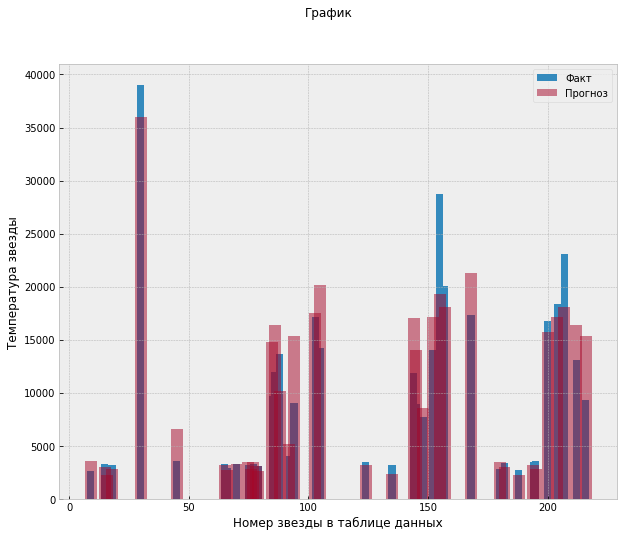

In [35]:
build_graphic()

### Вывод

Лучшее значение метрики RMSE на тестовой выборке - **3713.**<br>
Batch Normalization значительно улучшает сходимость обучения. А также при изменении гиперпараметров нейросеть давала более стабильные результаты, чем в других версиях.

### Dropout

In [36]:
class DP_Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
        super(DP_Net, self).__init__()
        self.layer1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=0.8)
        self.layer2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.dp2 = nn.Dropout(p=0.8)
        self.layer3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
        
    def forward(self, x):
        x = self.layer1(x)
        x = nn.functional.leaky_relu(x)
        x = self.dp1(x)
        x = self.layer2(x)
        x = self.dp2(x)
        x = nn.functional.leaky_relu(x)
        x = self.layer3(x)
        x = linear(x)
        
        return x

In [37]:
dp_net = DP_Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
dp_net.apply(init_weights)
optimizer = torch.optim.Adam(dp_net.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    order = np.random.permutation(len(X_train_tensor))
    optimizer.zero_grad()
    
    for batch_i in range(num_batches):
        
        start_index = batch_i * batch_size
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_tensor[batch_indexes]
        y_batch = y_train_tensor[batch_indexes]
        
        preds = dp_net.forward(X_batch).flatten()
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        if ((batch_i+1) % accumulation_iteration == 0) or (batch_i+1 == num_batches):
            optimizer.step()
            optimizer.zero_grad()
        if epoch % 100 == 0 or epoch == num_epochs-1:
            dp_net.eval()
            test_preds = dp_net.forward(X_test_tensor).flatten()
            mse = (torch.sum((y_test_tensor - test_preds)**2)/len(test_preds)).data
            rmse = np.sqrt(mse)
            print(f'Эпоха: {epoch}, Loss: {loss_value}, RMSE: {rmse}')

Эпоха: 0, Loss: 187692320.0, RMSE: 12411.4794921875
Эпоха: 0, Loss: 211191808.0, RMSE: 12411.4462890625
Эпоха: 100, Loss: 189954576.0, RMSE: 12408.81640625
Эпоха: 100, Loss: 207182912.0, RMSE: 12408.7607421875
Эпоха: 200, Loss: 184318320.0, RMSE: 12392.1533203125
Эпоха: 200, Loss: 214890960.0, RMSE: 12391.8310546875
Эпоха: 300, Loss: 219957984.0, RMSE: 12337.4560546875
Эпоха: 300, Loss: 149957696.0, RMSE: 12336.65234375
Эпоха: 400, Loss: 189969424.0, RMSE: 12224.8046875
Эпоха: 400, Loss: 188644576.0, RMSE: 12223.3359375
Эпоха: 500, Loss: 165514080.0, RMSE: 12038.861328125
Эпоха: 500, Loss: 211114496.0, RMSE: 12036.583984375
Эпоха: 600, Loss: 177712704.0, RMSE: 11769.4130859375
Эпоха: 600, Loss: 165052784.0, RMSE: 11766.296875
Эпоха: 700, Loss: 195162928.0, RMSE: 11416.853515625
Эпоха: 700, Loss: 103829552.0, RMSE: 11412.9453125
Эпоха: 800, Loss: 144131856.0, RMSE: 10985.068359375
Эпоха: 800, Loss: 151763856.0, RMSE: 10980.3525390625
Эпоха: 900, Loss: 147376528.0, RMSE: 10486.3447265625

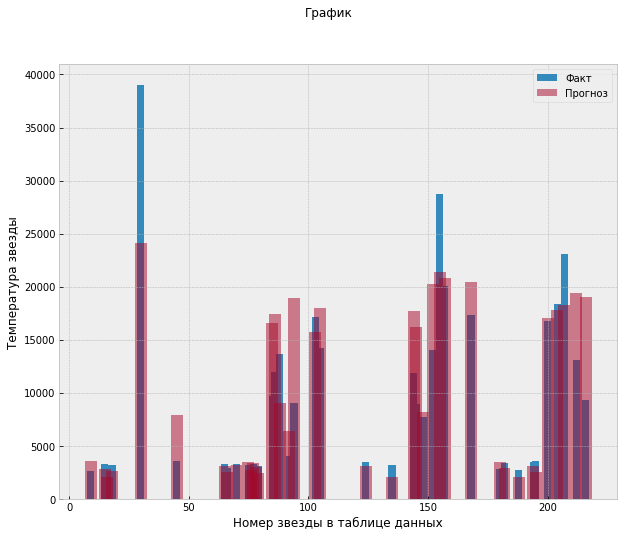

In [38]:
build_graphic()

Лучшее значение метрики RMSE на тестовой выборке - **3901**. Было достигнуто на 3000-й эпохе, после чего метрика начала падать. Однако, при каждом новом запуске результаты значительно отличаются. Этот вариант выглядит самым нестабильным из всех.

## Выводы

В целом, все 3 модели хорошо справляются с поставленной задачей. Базовая модель обучается медленно, но стабильно, и по ней легче отследить процесс обучения. BatchNorm работает быстрее, использование этой техники кажется предпочтительным. Dropout сильно зависит от изменения гиперпараметров и, есть ощущение, что для конкретно этой задачи не очень подходит.